# **Libraries**

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from tabulate import tabulate
from sklearn.metrics import classification_report, accuracy_score
import swifter
from tqdm import tqdm

from packages.preprocessing import preprocess_text

c:\Users\Enzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Loading Data**

In [2]:
path = os.getcwd()
path_data = os.path.join(path, 'data')

In [3]:
df = pd.read_csv(path_data + '/financial_phrasebank_sentences_75agree.csv')

In [4]:
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|    | sentence                                                                                                                                                                                                       |   label |
|----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------|
|  0 | According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .                                                                                |       1 |
|  1 | With the new production plant the company would increase its capacity to meet the expecte

# **Part 0: Dataset Selection**

- Objective: Financial Phrasebank - HuggingFace hub.
- This dataset includes sentences from financial news.
  
# **Part 1: Setting Up the Problem** (1.5 points)

- **Objective**: Understand and establish the baseline for your chosen dataset.


### a. Bibliography and SOA (0.25 points):
  -  **Main Objective**: The task is a **multiclass sentiment classification** problem in the financial domain. Given a sentence from a financial news article, the model must classify it as:
     - 0 → Negative
     - 1 → Neutral
     - 2 → Positive
  -  **Business Application**: Financial sentiment analysis aids automated trading, risk alert systems, investment strategies, and the prevention of significant losses.
  
  -  **Benchmark**: According with some papers the tipical models used as a benchmark is LSTM.

### b. Dataset Description (0.5 points):

Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics.

**Preprocessing**

In this step, we are applying the following preprocessing pipeline to each sentence in the dataset:

1. **Lowercasing** → Converts all characters to lowercase for uniformity.
2. **Digit and Punctuation Removal** → Removes numbers, punctuation, and extra spaces using regular expressions.
3. **Tokenization** → Splits sentences into individual words using NLTK's `word_tokenize`.
4. **Stopword Removal** → Filters out common English stopwords using NLTK's predefined list. Only tokens with 3 or more characters are kept.
5. **POS Tagging & Lemmatization** → Performs part-of-speech tagging and then lemmatizes tokens using NLTK's `WordNetLemmatizer`, which helps group different forms of a word together (e.g., “increased” → “increase”).

**Note:** This preprocessing pipeline is designed for exploratory analysis and rule-based models. It should **not** be used prior to Transformer models like BERT, which require raw text and their own tokenizer.

In [5]:
df = preprocess_text(df, col='sentence')

print(f'Total number of rows: {len(df)}')

Total number of rows: 3453


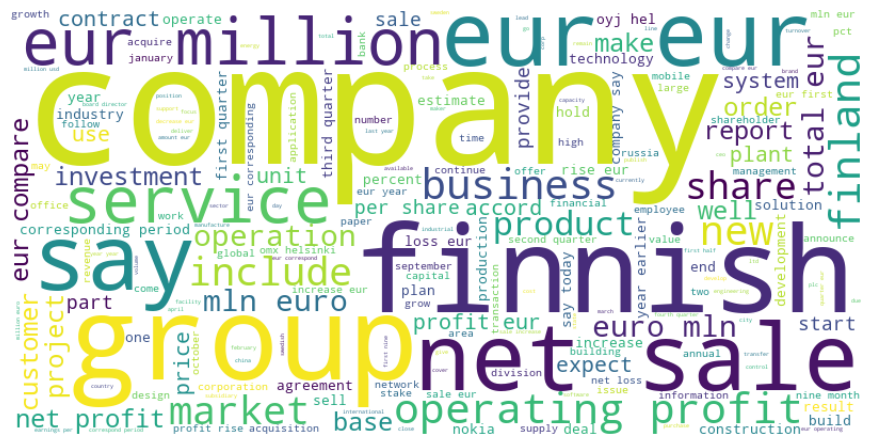

In [6]:
# This helps to quickly identify the dominant terms and themes present in the dataset after cleaning.
text = ' '.join(df['clean_sentence'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(11, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

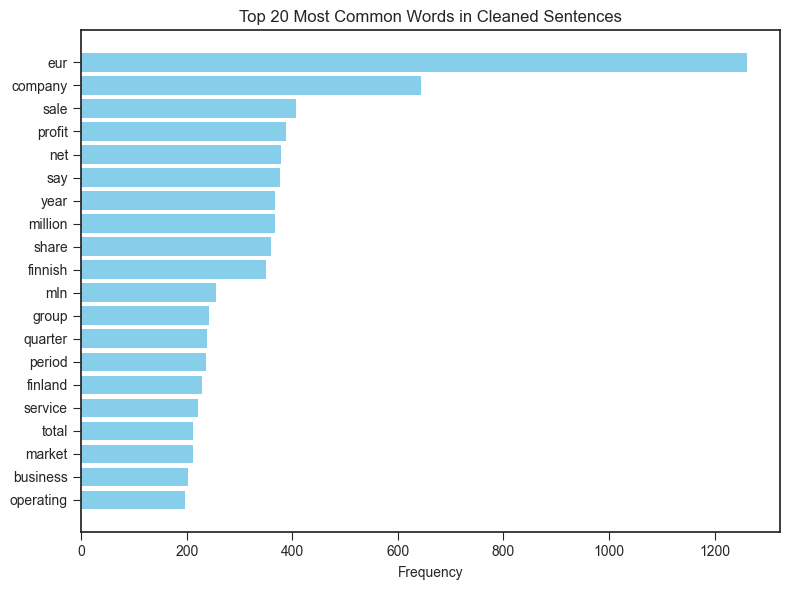

In [7]:
# Count the most common words in 'clean_sentence'
all_words = ' '.join(df['clean_sentence']).split()
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

words, counts = zip(*most_common)

plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(8, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel('Frequency', fontsize=10, labelpad=5)
plt.title('Top 20 Most Common Words in Cleaned Sentences', fontsize=12)
plt.tight_layout()
plt.show()

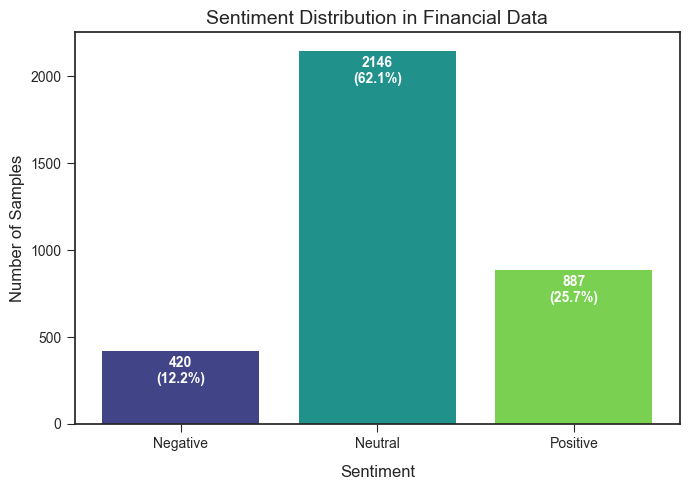

In [8]:
# In the next plot we can see the distribution for our target!
class_counts = df['label'].value_counts().sort_index()
class_percent = df['label'].value_counts(normalize=True).sort_index() * 100

labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(class_counts)))

# Plot configuration
plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(7, 5))
bars = plt.bar(class_counts.index, class_counts, color=colors)

plt.xticks([0, 1, 2], ["Negative", "Neutral", "Positive"], fontsize=10)
plt.xlabel('Sentiment', fontsize=12, labelpad=10)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Sentiment Distribution in Financial Data', fontsize=14)

# Annotate bars with counts and percentages, adjusting position
for bar, count, percent in zip(bars, class_counts, class_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 30, 
            f"{count}\n({percent:.1f}%)", ha='center', va='top', 
            fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

In [9]:
# Key Statistics for Sentence Length by Label
df['sentence_length'] = df['sentence'].apply(lambda x: len(word_tokenize(x)))

stats = df.groupby('label')['sentence_length'].agg(['mean', 'min', 'max', 'std', 'median', 'count']).rename(index=labels)
print(tabulate(stats, headers='keys', tablefmt='psql'))

+----------+---------+-------+-------+----------+----------+---------+
| label    |    mean |   min |   max |      std |   median |   count |
|----------+---------+-------+-------+----------+----------+---------|
| Negative | 24.5167 |     5 |    56 | 10.1632  |       22 |     420 |
| Neutral  | 21.6034 |     2 |    81 |  9.82973 |       20 |    2146 |
| Positive | 24.9064 |     6 |    57 | 10.3279  |       23 |     887 |
+----------+---------+-------+-------+----------+----------+---------+


### c. Random Classifier Performance (0.25 points):
Calculate the expected performance of a random classifier for your dataset to set a benchmark. The calculation should include an  implementation.

To establish a lower-bound **benchmark**, we evaluate the performance of two types of **random classifiers**:

1. **Weighted Random Classifier**:  
   This classifier predicts labels according to the empirical class distribution in the dataset. The expected accuracy is calculated as:
   
   $\text{Expected Accuracy} = \sum_{i=1}^{C} P_i^2$

   where $P_i$ is the observed probability of class $i$.

2. **Simulated Weighted Random Classifier**:  
   To validate the expected accuracy, we simulate the predictions over 1000 trials. In each trial, labels are randomly assigned to the samples based on the same empirical distribution. We report the mean and standard deviation of the resulting accuracies across trials.

This gives us a concrete, reproducible benchmark to compare future models against.

In [10]:
# First, calculate the empirical distribution of the labels
label_counts = df['label'].value_counts(normalize=True).sort_index()
label_probs = label_counts.values

# --- Weighted Random Classifier ---
expected_accuracy_weighted = np.sum(label_probs ** 2)
print(f"Expected accuracy (Weighted Random Classifier): {expected_accuracy_weighted * 100:.2f}%")

Expected accuracy (Weighted Random Classifier): 46.70%


In [11]:
# --- Simulation Random Classifier ---
n_trials = 1000
sample_size = len(df)
accuracies = []

for _ in range(n_trials):
    random_preds = np.random.choice(df['label'].unique(), size=sample_size, p=label_probs)
    acc = accuracy_score(df['label'], random_preds)
    accuracies.append(acc)

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Simulated Random Classifier Accuracy: {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")

Simulated Random Classifier Accuracy: 26.62% ± 0.65%


### d. Baseline Implementation (0.5 points): 
Develop a rule-based classifier as a baseline. Discuss its performance in the context of the dataset's complexity and compare it with human-level performance if available.

We implemented a **rule-based keyword classifier** that assigns sentiment classes based on the presence of specific financial terms in each sentence.

- **Class 2 (Positive):** If the sentence contains any positive keywords such as _profit_, _revenue_, _growth_, _increase_, or related financial terms.
- **Class 0 (Negative):** If the sentence contains any negative keywords such as _loss_, _decline_, _decrease_, _risk_, or similar.
- **Class 1 (Neutral):** If the sentence contains neutral or forward-looking keywords such as _plan_, _contract_, _forecast_, or if no keywords from positive or negative lists are found (default class).

In [13]:
def rule_based_classifier(text):
    positive_keywords = ['profit', 'revenue', 'result', 'sale', 'income', 'operating', 'quarter', 'net', 'mln', 'million', 'billion', 'growth', 'earnings', 'report', 'margin', 'increase', 'rise', 'compare', 'estimate', 'value', 'financial']
    neutral_keywords = ['expect', 'plan', 'will', 'forecast', 'agreement', 'contract', 'project', 'develop', 'market', 'build', 'acquisition', 'start', 'construction', 'deal', 'estimate', 'future', 'provide', 'service']
    negative_keywords = ['loss', 'decline', 'decrease', 'fell', 'drop', 'cost', 'risk', 'reduce', 'negative']
    
    text = text.lower()
    if any(word in text for word in positive_keywords):
        return 2 
    elif any(word in text for word in negative_keywords):
        return 0  
    elif any(word in text for word in neutral_keywords):
        return 1 
    else:
        return 1  # if it is not in any list, it will be neutral! 

df['rule_pred'] = df['clean_sentence'].apply(rule_based_classifier)

print(classification_report(df['label'], df['rule_pred'], digits=3))

              precision    recall  f1-score   support

           0      0.426     0.069     0.119       420
           1      0.808     0.691     0.745      2146
           2      0.374     0.654     0.476       887

    accuracy                          0.606      3453
   macro avg      0.536     0.471     0.447      3453
weighted avg      0.650     0.606     0.600      3453

